In [1]:
from torch.optim import Adam
from gpytorch.optim import NGD
from experiments.partial import build_partial, plot_partial
from pathlib import Path
import numpy as np

from lafomo.datasets import DrosophilaSpatialTranscriptomics, HomogeneousReactionDiffusion
from lafomo.trainers import PartialPreEstimator
from lafomo.plot import plot_spatiotemporal_data
from lafomo.plot.misc import plot_variational_dist
from lafomo.utilities.torch import spline_interpolate_gradient, softplus

from matplotlib import pyplot as plt
import torch
from lafomo.configuration import VariationalConfiguration

In [2]:
drosophila = True
kni_params = dict(sensitivity=0.183,
                  decay=0.0770,
                  diffusion=0.0125)
gt_params = dict(sensitivity=0.1107,
                  decay=0.1110,
                  diffusion=0.0159)
kr_params = dict(sensitivity=0.0970,
                 decay=0.0764,
                 diffusion=0.0015)
params = dict(kr=kr_params, kni=kni_params, gt=gt_params)
if drosophila:
    gene = 'kni'
    data = 'dros-kni'
    dataset = DrosophilaSpatialTranscriptomics(
        gene=gene, data_dir='../../../data', scale=True)
    params = dict(lengthscale=10,
                  **params[gene],
                  parameter_grad=False,
                  warm_epochs=-1,
                  natural=False,
                  zero_mean=True,
                  clamp=True)
    disc = dataset.disc
else:
    data = 'toy-spatial'
    dataset = HomogeneousReactionDiffusion(data_dir='../../../data')
    params = dict(lengthscale=0.2,
                  sensitivity=1,
                  decay=0.1,
                  diffusion=0.01,
                  warm_epochs=-1,
                  dp=0.025,
                  natural=False,
                  clamp=False)
    disc = 1
model_name = '0savedmodel'
# model_name = 'epoch165'
# model_name = 'model_with_3'
lfm, trainer, plotter = build_partial(
    dataset,
    params)#,
    # reload=f'../../../experiments/{data}/partial/{model_name}')

x dp is set to tensor(1., dtype=torch.float64)


'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


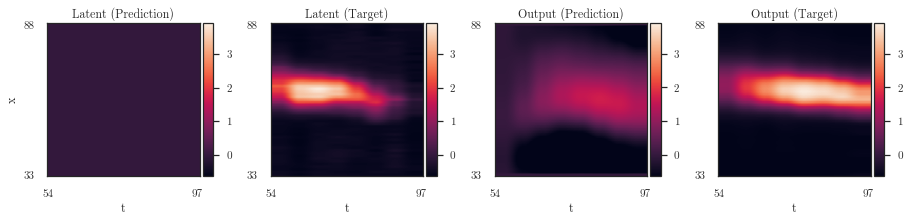

In [4]:
plot_partial(dataset, lfm, trainer, plotter, Path('./'), params)

36 57
torch.Size([8, 57])
torch.Size([1, 456])


/Users/jacob/miniconda3/envs/wishart/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


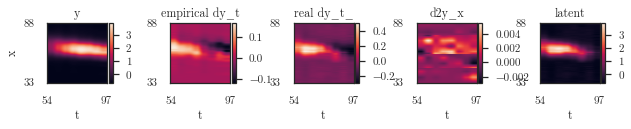

In [8]:
from lafomo.utilities.torch import inv_softplus
sensitivity = (torch.tensor(params['sensitivity']))
decay = (torch.tensor(params['decay']))
diffusion = (torch.tensor(params['diffusion']))
orig_data = dataset.orig_data.squeeze().t()
num_t_orig = orig_data[:, 0].unique().shape[0]
num_x_orig = orig_data[:, 1].unique().shape[0]

tx = trainer.tx
num_t = tx[0, :].unique().shape[0]
num_x = tx[1, :].unique().shape[0]
print(num_t, num_x)
y_target = trainer.y_target[0]
y_matrix = y_target.view(num_t_orig, num_x_orig)
print(y_matrix.shape)
dy_t = list()
for i in range(num_x_orig):
    t = tx[0][::disc][::num_x]
    y = y_matrix[:, i].unsqueeze(-1)
    t_interpolate, y_interpolate, y_grad, _ = \
        spline_interpolate_gradient(t, y)
    dy_t.append(y_grad)
dy_t = torch.stack(dy_t)

# fig, axes = plt.subplots(nrows=2, figsize=(5, 7))
d2y_x = list()
dy_x = list()
for i in range(num_t_orig):
    t = tx[1][::disc][:num_x]
    y = y_matrix[i].unsqueeze(-1)
    t_interpolate, y_interpolate, y_grad, y_grad_2 = \
        spline_interpolate_gradient(t, y)
    d2y_x.append(y_grad_2)
    # axes[0].plot(t_interpolate, y_interpolate)
    #
    # axes[1].plot(y_grad_2)
    dy_x.append(y_grad)

d2y_x = torch.stack(d2y_x)
dy_x = torch.stack(dy_x)[..., ::10, 0].reshape(1, -1)
d2y_x = d2y_x[..., ::10, 0].reshape(1, -1)
dy_t = dy_t[..., ::10, 0].t().reshape(1, -1)

def pde_func(y, u, sensitivity, decay, diffusion):
    # y (1, 1681) u (25, 1, 41, 41) s (25, 1)
    dy_t = (sensitivity * u.view(u.shape[0], -1) -
            decay * y.view(1, -1) +
            diffusion * d2y_x)
    return dy_t

u = orig_data[trainer.t_sorted, 2].view(num_t_orig, num_x_orig)
u = u.view(1, -1)
print(u.shape)
dy_t_ = pde_func(
    trainer.y_target,
    u.repeat(25, 1),
    sensitivity.unsqueeze(0).repeat(25, 1),
    decay.unsqueeze(0).repeat(25, 1),
    diffusion.unsqueeze(0).repeat(25, 1))[0]

ts = tx[0, :].unique().numpy()
xs = tx[1, :].unique().numpy()
extent = [ts[0], ts[-1], xs[0], xs[-1]]
axes = plot_spatiotemporal_data(
    [
        trainer.y_target.view(num_t_orig, num_x_orig).t(),
        dy_t.reshape(num_t_orig, num_x_orig).t(),
        dy_t_.view(num_t_orig, num_x_orig).t(),
        d2y_x.view(num_t_orig, num_x_orig).t(),
        torch.tensor(orig_data[trainer.t_sorted, 2]).view(num_t_orig, -1).t(),
    ],
    extent, titles=['y', 'empirical dy_t', 'real dy_t_', 'd2y_x', 'latent']
)

In [9]:
train_ratio = 0.3
num_training = int(train_ratio * tx.shape[1])
if params['natural']:
    variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.1)
    parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.05)
    optimizers = [variational_optimizer, parameter_optimizer]
else:
    optimizers = [Adam(lfm.parameters(), lr=0.09)]


pre_estimator = PartialPreEstimator(
    lfm, optimizers, dataset, pde_func,
    input_pair=(trainer.tx, trainer.y_target), target=dy_t.t(),
    train_mask=trainer.train_mask
)

In [23]:
import time
t0 = time.time()
lfm.pretrain(True)
lfm.config.num_samples = 50
times = pre_estimator.train(50, report_interval=5)
lfm.config.num_samples = 5


Epoch 051/100 - Loss: 0.56 (0.22 0.35) kernel: [[[15.05392944  8.81449678]]]
Epoch 056/100 - Loss: 0.24 (0.16 0.08) kernel: [[[15.5771894   8.47077385]]]
Epoch 061/100 - Loss: 0.16 (0.11 0.05) kernel: [[[15.94078751  8.20312085]]]
Epoch 066/100 - Loss: 0.08 (0.05 0.03) kernel: [[[16.18426727  8.07917772]]]
Epoch 071/100 - Loss: 0.01 (-0.01 0.02) kernel: [[[16.35632922  7.99231835]]]
Epoch 076/100 - Loss: -0.05 (-0.07 0.02) kernel: [[[16.55218441  7.92167017]]]
Epoch 081/100 - Loss: -0.11 (-0.13 0.02) kernel: [[[16.76913208  7.92911757]]]
Epoch 086/100 - Loss: -0.16 (-0.18 0.02) kernel: [[[16.99135292  8.06427824]]]
Epoch 091/100 - Loss: -0.20 (-0.24 0.03) kernel: [[[17.33914887  8.43948728]]]
Epoch 096/100 - Loss: -0.24 (-0.29 0.05) kernel: [[[17.94437483  8.72920363]]]


torch.Size([456, 1])
torch.Size([456, 1]) torch.Size([456]) torch.Size([456, 1])
prot Q2 tensor(0.6122, dtype=torch.float64)
prot CA tensor(0.4649, dtype=torch.float64)
mrna Q2 tensor(0.5694, dtype=torch.float64)
mrna CA tensor(0.7039, dtype=torch.float64)
(50, 2)


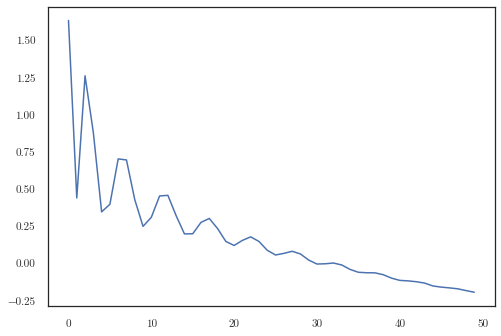

In [11]:
from lafomo.utilities.torch import q2, cia
lfm.eval()
f = lfm(tx)
print(f.mean.shape)
f_mean = f.mean.detach()
f_var = f.variance.detach()
y_target = trainer.y_target[0]
def cia(y_test, f_mean, f_var):
    return ((y_test >= (f_mean - 1 * f_var.sqrt())) &
            (y_test <= (f_mean + 1 * f_var.sqrt()))).double().mean()

print(f_mean.shape, y_target.shape, f_var.shape)
print('prot Q2', q2(y_target.squeeze(), f_mean.squeeze()))
print('prot CA', cia(y_target.squeeze(), f_mean.squeeze(), f_var.squeeze()))
gp = lfm.gp_model(tx.t())
lf_target = orig_data[trainer.t_sorted, 2]
f_mean = gp.mean.detach().view(num_t, num_x)[::disc].reshape(-1)
f_var = gp.variance.detach().view(num_t, num_x)[::disc].reshape(-1)

print('mrna Q2', q2(lf_target.squeeze(), f_mean.squeeze()))
print('mrna CA', cia(lf_target.squeeze(), f_mean.squeeze(), f_var.squeeze()))


print(np.stack(times).shape)
plt.plot(np.stack(times)[:, 1])

/Users/jacob/miniconda3/envs/wishart/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[0.10020655891674712, 0.07700004100841877, 0.012500035940929638]


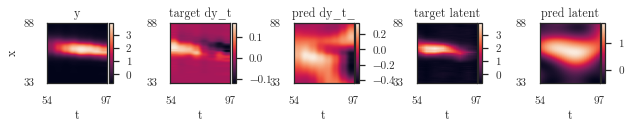

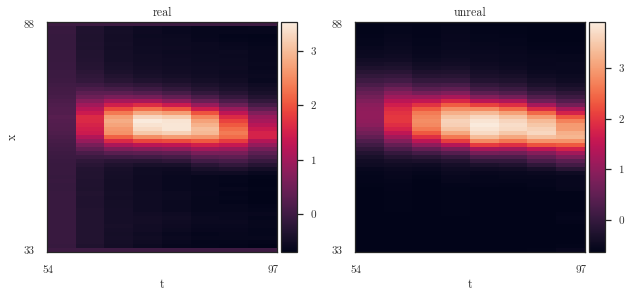

In [12]:
lfm.config.num_samples = 5
lfm.eval()
u = lfm.gp_model(trainer.tx.t()).sample(torch.Size([5])).permute(0, 2, 1)
u = u.view(*u.shape[:2], num_t, num_x)
dy_t_ = pde_func(
    trainer.y_target,
    u[:, :, ::disc].contiguous(),
    sensitivity.unsqueeze(0).repeat(5, 1),
    decay.unsqueeze(0).repeat(5, 1),
    diffusion.unsqueeze(0).repeat(5, 1))[0]

from scipy.interpolate import interp1d
time = tx[0].unique()
time = dataset.orig_data[0].unique()
latent = torch.tensor(orig_data[trainer.t_sorted, 2]).unsqueeze(0)
latent = latent.repeat(lfm.config.num_samples, 1, 1)
latent = latent.view(lfm.config.num_samples, 1, num_t_orig, num_x_orig)
time_interp = tx[0].unique()
latent = torch.from_numpy(interp1d(time, latent, axis=2)(time_interp))
real = lfm.solve_pde(latent).mean(0)

unreal = lfm.solve_pde(u.view(5, 1, num_t, num_x)).mean(0)

ts = tx[0, :].unique().numpy()
xs = tx[1, :].unique().numpy()
extent = [ts[0], ts[-1], xs[0], xs[-1]]
axes = plot_spatiotemporal_data(
    [
        trainer.y_target.view(num_t_orig, num_x_orig).t(),
        dy_t.reshape(num_t_orig, num_x_orig).t(),
        dy_t_.view(num_t_orig, num_x_orig).t(),
        latent[0].view(num_t, num_x).t(),
        u.mean(0).view(num_t, num_x).t(),
    ],
    extent, titles=['y', 'target dy_t', 'pred dy_t_', 'target latent', 'pred latent']
)
plot_spatiotemporal_data(
    [
        real.t().detach(),
        trainer.y_target.view(num_t_orig, num_x_orig).t(),
        # unreal.t().detach()
    ],
    extent, titles=['real', 'unreal']
)
print([softplus(param).item() for param in lfm.fenics_parameters])

Mean output variance: 2.288605264251212
Test loss: 7.861314868647865
Q2: 0.752
Q2 tensor(0.6959, dtype=torch.float64)
CA tensor(0.9649, dtype=torch.float64)
Epoch 211/260 - Loss: 6.94 (0.76 6.18) kernel: [[[19.10609947  7.99859552]]] s: 0.10020655891674712 dec: 0.07700004100841877 diff: 0.012500035940929638
Mean output variance: 2.0965490637239497
Test loss: 6.18275346672858
Q2: 0.906
Q2 tensor(0.7096, dtype=torch.float64)
CA tensor(0.9605, dtype=torch.float64)
Epoch 221/260 - Loss: 5.40 (0.61 4.79) kernel: [[[19.04710098  7.91450985]]] s: 0.10020655891674712 dec: 0.07700004100841877 diff: 0.012500035940929638
Mean output variance: 1.4079596379017942
Test loss: 4.6599572378428515
Q2: 0.915
Q2 tensor(0.7116, dtype=torch.float64)
CA tensor(0.9561, dtype=torch.float64)
Epoch 231/260 - Loss: 4.01 (0.50 3.51) kernel: [[[19.00188813  7.9949429 ]]] s: 0.10020655891674712 dec: 0.07700004100841877 diff: 0.012500035940929638
Mean output variance: 1.638732968578047
Test loss: 4.130110063201095
Q2

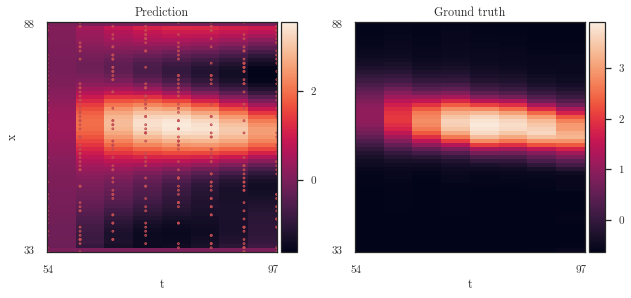

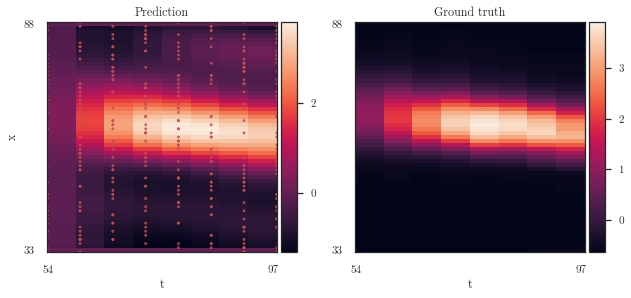

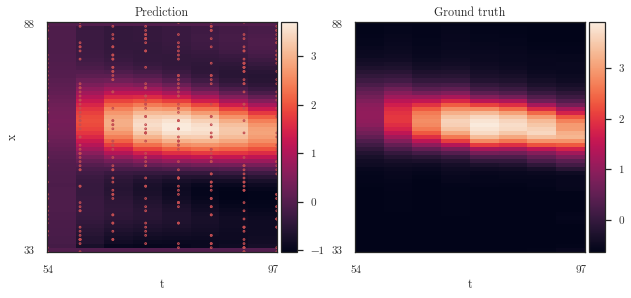

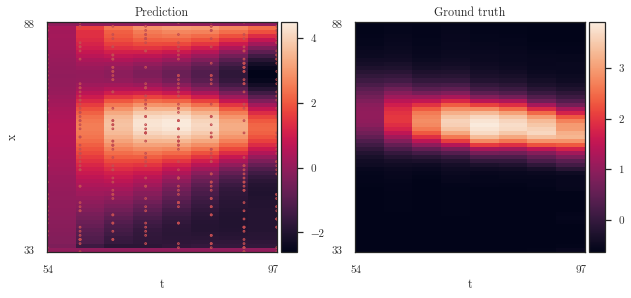

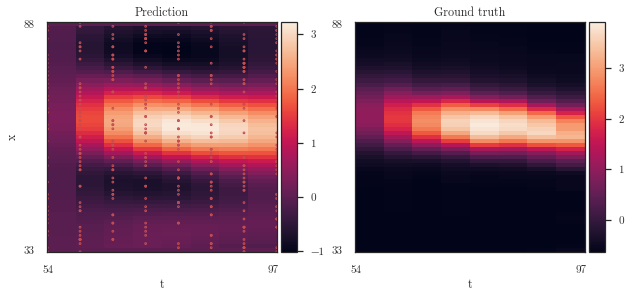

In [26]:
lfm.config.num_samples = 10
trainer.plot_outputs = True
lfm.pretrain(False)
trainer.train(50, report_interval=10);

In [16]:
# for key in trainer.parameter_trace.keys():
#     params = torch.stack(trainer.parameter_trace[key])
#     for i in range(1, params.ndim):
#         params = params.mean(-1)
    # plt.figure()
    # plt.plot(params)
[softplus(param) for param in lfm.fenics_parameters]

'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


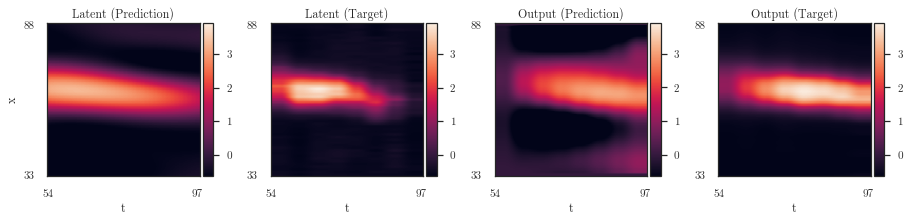

In [25]:
from lafomo.plot import tight_kwargs
plot_partial(dataset, lfm, trainer, plotter, Path('./'), params)

# plt.savefig(Path('./') / f'kinetics-{gene}.pdf', **tight_kwargs)

In [18]:
from lafomo.utilities.torch import q2, cia
tx = trainer.tx
num_t = tx[0, :].unique().shape[0]
num_x = tx[1, :].unique().shape[0]
f = lfm(tx)
f_mean = f.mean.detach()
f_var = f.variance.detach()
y_target = trainer.y_target[0]
def cia(y_test, f_mean, f_var):
    return ((y_test >= (f_mean - 1 * f_var.sqrt())) &
            (y_test <= (f_mean + 1 * f_var.sqrt()))).double().mean()

print(f_mean.shape, y_target.shape, f_var.shape)
print('Q2', q2(y_target.squeeze(), f_mean.squeeze()))
print('CA', cia(y_target.squeeze(), f_mean.squeeze(), f_var.squeeze()))

torch.Size([456, 1]) torch.Size([456]) torch.Size([456, 1])
Q2 tensor(0.8679, dtype=torch.float64)
CA tensor(0.7105, dtype=torch.float64)


In [20]:
gp = lfm.gp_model(tx.t())
lf_target = orig_data[trainer.t_sorted, 2]
f_mean = gp.mean.detach().view(num_t, num_x)[::disc].reshape(-1)
f_var = gp.variance.detach().view(num_t, num_x)[::disc].reshape(-1)

print('Q2', q2(lf_target.squeeze(), f_mean.squeeze()))
print('CA', cia(lf_target.squeeze(), f_mean.squeeze(), f_var.squeeze()))


Q2 tensor(0.6158, dtype=torch.float64)
CA tensor(0.8706, dtype=torch.float64)


In [ ]:
lfm.save('./kr-1205')

In [ ]:
lfm2, trainer2, plotter2 = build_partial(
    dataset,
    params,
    reload='./kr-1205')

In [ ]:
gp = lfm2.gp_model(tx.t())
lf_target = orig_data[trainer.t_sorted, 2]
f_mean = gp.mean.detach()
f_var = gp.variance.detach()

print('Q2', q2(lf_target.squeeze(), f_mean.squeeze()))
print('CA', cia(lf_target.squeeze(), f_mean.squeeze(), f_var.squeeze()))
